# Variational Auto Encoder for Super Resolution

This notebook contains the architecture of a variational auto encoder (VAE) for taking 16x16 images and outputting 
32x32 pixel images, both of which are 3-channel RGB. This is mostly a proof-of-concept since the images are very low resolution. This
makes training easier and faster, and less memory is used.

This notebook is for the final project in Deep Learning.

## The CIFAR10 Data

The data used for this project is the [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10) data set. It consists of 60,000 32x32 pixel 3 channel (RGB) images. For the project, the goal is to take 16x16 pixel images of 3 channels and output the original 32x32 pixel RGB image.

## Preparation of notebook

First, packages will be installed and imported for the notebook. [PyTorch](https://pytorch.org/) is used for defining the neural networks. 


In [ ]:
!pip install seaborn==0.11.0
!pip install torchvision
!pip install scikit-image

In [ ]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
from skimage.transform import resize
from torch.utils.data import random_split
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
import torchvision.transforms as transforms
import torchvision
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.distributions import Bernoulli, Normal, MultivariateNormal
from plotting import make_vae_plots
from discretized_mixture_logits import DiscretizedMixtureLogitsDistribution

## Loading and Preparation of Data

The data are of standard RGB values 0-255. It will be loaded and scaled to the interval \[0,1] to get a continuous interval for the networks to work with.


In [ ]:
### Load data here
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Make a transformer to scale the data in interval [0,1]
transform = transforms.Compose(
    [transforms.ToTensor()
    ]
)

# Load the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)



# Create the trainset of tensor images:
output = []
for datapoint in trainset:
    image = datapoint[0]
    output.append(torch.Tensor(image))
trainset = []
for i in range(len(output)):
    trainset.append(((output[i])))


# Split into train and validation (not all will be used however)
train_size = len(trainset)
val_size = int(np.floor(train_size * 0.1))
train_size = int(train_size - val_size)
trainset, validset = random_split(trainset, [train_size, val_size])

# Create train and validation loaders:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(validset, batch_size=10,
                                          shuffle=True, num_workers=0)


## Reparametrization Trick

We will use Gaussian distribution throughout. For making it able to use the gradient, the reparametrization trick will be used. Let $x\sim N(\mu,\sigma^2)$, then we can reparametize it as

$$x = \mu + \sigma\epsilon,$$

where $\epsilon \sim N(0,1)$. We define the distribution below.

In [ ]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        #return torch.normal(mean = self.mu, std = self.sigma) 
        return self.mu + self.sigma*self.sample_epsilon()
        #raise NotImplementedError # <- your code
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        #dist = torch.distributions.Normal(self.mu, self.sigma)
        #return dist.log_prob(z)
        return torch.log(1e-3+1/(self.sigma*np.sqrt(2*np.pi))) -1/2*((z-self.mu)/(self.sigma+1e-3))**2
        #raise NotImplementedError # <- your code

## Defining the VAE

We will now define the VAE. We use several neural networks to do so. We need distribution $q_{\phi}(z|x) = N(z|\mu_x,\sigma_x)$ 
defined from a neural network `encoder` taking the input full-sized image $x$ as input. We also define distribution $p(z|y)=N(z|\mu_y,\sigma_y)$,
which is defined as a neural netork `downsized` taking the downscaled image $y$
as input. Lastly we want to reconstruct $p(x|z,y)$. This is done by inserting the latent variable $z$ into a `decoder`, adding it to the
downscaled image $y$ and then upsampling into the correct size using a fully connected neural network `upsample`.

The distribution $p(x|z,y) = N(x|\mu_{z,y},\hat{\sigma})$, where $\hat{\sigma}$ is a constant standard deviation. From testing it was found that a
$\hat{\sigma} = [\text{e}^{-2},\text{e}^{-10}]$ is a good range. Choosing a constant standard deviation is similar to using the MSE as a 
loss criteria for the loss function. 

The neural networks are chosen as either fully connected layers or a combination of convolutional and fully connected layers.

In [ ]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        self.logsigma = nn.Parameter(1e-2*torch.ones(1), requires_grad=False)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential( # Take big image, return small image
            nn.Conv2d(3, 5, 3, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(5, 7, 3, stride=2, padding=0),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(7, 8, 3),
            nn.Flatten(start_dim=1, end_dim = -1),
            nn.Linear(in_features=1152, out_features=600),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=600, out_features=200),
            #nn.LeakyReLU(negative_slope=0.01),
            #nn.Linear(in_features=200, out_features=200),
        )


        # For creating the latent variable for the distribution p(x|z,y) = N(x|\mu(y+z), \sigma), where \sigma is constant.
        self.decoder = nn.Sequential(
            nn.Linear(in_features=100, out_features=200),
            #nn.LeakyReLU(negative_slope=0.01),
            #nn.Linear(in_features = 64, out_features=256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=200, out_features=512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=512, out_features=3*16*16),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Unflatten(dim = 1, unflattened_size=(3,16,16)),
        )

        # Upsampling to get \mu(y+z) for the distribution p(x|z,y) = N(x|\mu(y+z), \sigma)
        self.upsample = nn.Sequential(
            nn.Flatten(start_dim = 1, end_dim = -1),
            nn.Linear(in_features=3*16*16, out_features= 3*32*32),
            #nn.LeakyReLU(negative_slope=0.01),
            #nn.Linear(in_features=3*32*16, out_features= 3*32*32),
        )

        # Return distribution p(z|y) = N(z|mu(y),sigma(y))
        self.downsized = nn.Sequential( # Take big image, return small image
            nn.Conv2d(3, 5, 3, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(5, 7, 3, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(7, 8, 3),
            nn.Flatten(start_dim = 1, end_dim = -1),
            nn.Linear(in_features=800, out_features=500),
            nn.LeakyReLU(negative_slope=0.01),
            #nn.Linear(in_features=500, out_features=150),
            #nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=500, out_features=200),
        )

        
        # define the parameters of the prior, chosen as p(z) = N(0, I). p(z) = N(y,s*diag(y))
        #self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(z|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma = h_x.chunk(2, dim=-1)
        
        # return the distribution `p(z|y)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def prior(self, y:Tensor)-> Distribution:
        """return the distribution `p(z|y)`"""
        # compute the parameters of the prior
        h_y = self.downsized(y)
        mu, log_sigma = h_y.chunk(2, dim=-1)

        # return the distribution `p(z|y)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor, y:Tensor) -> Distribution:
        """return the distribution `p(x|z,y)`"""
        # Get new latent variable of same dimension as y:
        tmp = self.decoder(z)
        #h = torch.cat([tmp, y],1)
        #print(h.shape)
        #mu = self.upsample(h)
        # h = z+y
        h = torch.add(tmp,y)
        # \mu_{z+y} gotten here:
        mu = self.upsample(h)
        # Constant variance:
        log_sigma = -3*torch.ones(mu.shape)
        # Return the distribution:
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        y = torch.from_numpy(resize(x, output_shape = (10,3,16,16), mode = 'reflect', anti_aliasing=True))
        pz = self.prior(y)
 
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
     
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        #print("sampled z: ", z.shape)
        
        # define the observation model p(x|z+y) = B(x | g(z))
        px = self.observation_model(z, y)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, x:Tensor):
        """sample z~p(z|y) and return p(x|z)"""
        y = torch.from_numpy(resize(x, output_shape = (10,3,16,16), mode = 'reflect', anti_aliasing=True))
        #y = y.view(y.size(0), -1)
        # degine the prior p(z)
        pz = self.prior(y)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z, y)
        
        return {'px': px, 'pz': pz, 'z': z}


## Variational Inference

Here we calculate the loss for the VAE using the ELBO. We output the different distributions from the VAE and get the EBLO (let $\mu$ define the mean operator):

$$ELBO = \log(p_x(x))-\beta(\log(q_z(z))-\log(p_z(z)),$$

where $p_x$ is the distribution $p(x|z,y)$ from the VAE, $q_z$ is $q(z|x)$ and $p_z$ is $p(z|y)$. The inputs $x$ and $z$ is the full image
and the latent variable from the VAE respectively. The loss is then defined as

$$loss = -\mu(ELBO)$$.

In [ ]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]

        #ltest2 = nn.CrossEntropyLoss()
        
        # evaluate log probabilities
        #ltest = nn.MSELoss()
        #print(px.shape)
        #print(x.shape)
        #log_px = -ltest(px,x.view(-1,3*32*32))
        #px = DiscretizedMixtureLogitsDistribution(3, px)
        
        log_px = reduce(px.log_prob(x.view(-1,3*32*32)))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        #print("px:", torch.log(l2))
        #print("pz:", log_pz)
        #print("qz:", log_qz)
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl# <- your code here
        beta_elbo = log_px - self.beta*kl# <- your code here
        #print("kl: ", kl)
        #print("ELBO: ", beta_elbo)
        
        # loss
        loss = -beta_elbo.mean()
        #print("loss:", loss)
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

## Training the Network

Now it is time to train the VAE in order to be able to input a downscaled image $y$ and get the full image out. We first define the different
parameters needed, and then a training loop will run, outputting the important values of the training. We expect the loss to decrease
throughout the training. 

In [ ]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
images = next(iter(train_loader))
latent_features = 16*16*3
vae = VariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 0.9
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

pp = get_n_params(vae)
print(pp)

4194113


In [ ]:
num_epochs = 30

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)
nsamples = 300
nsamples2 = 1000

elbodat = []
logpxdat = []
kldat = []
trainlossdat = []
vallosdat = []

# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    vae.train()
    running_loss = 0
    c = 0
    ct = 0
    print("EPOCH ", epoch, " -----------------")
    
    # Go through each batch in the training dataset using the loader
    for i, x in enumerate(train_loader):
        if i > nsamples:
            break
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        tmp = loss.clone()
        running_loss += tmp.detach().numpy()
        ct += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    # Print:  
    print("Running Loss: ", running_loss/ct)
    trainlossdat.append(running_loss/ct)
    print("log_px: ", np.mean(training_epoch_data["log_px"]))
    logpxdat.append(np.mean(training_epoch_data["log_px"]))
    print("Elbo: ", np.mean(training_epoch_data["elbo"]))
    elbodat.append(np.mean(training_epoch_data["elbo"]))
    print("KL: ", np.mean(training_epoch_data["kl"]))
    kldat.append(np.mean(training_epoch_data["kl"]))
    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x = next(iter(val_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
        

    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    #make_vae_plots(vae, x[:,1,:,:], np.ones(x.shape), outputs, training_data, validation_data)
    

>> Using device: cpu
EPOCH  1  -----------------
Running Loss:  9444.099103883256
log_px:  -9393.746852897528
Elbo:  -9449.693821295552
KL:  55.94689050366316
EPOCH  2  -----------------
Running Loss:  -171.0224948563053
log_px:  209.3117400593932
Elbo:  166.76814096393775
KL:  42.54361036687198
EPOCH  3  -----------------
Running Loss:  -1772.8499260107149
log_px:  1798.9336146516262
Elbo:  1769.9517500487673
KL:  28.981868398545984
EPOCH  4  -----------------
Running Loss:  -2710.8141193579995
log_px:  2728.2821584302324
Elbo:  2708.8732135557257
KL:  19.40893786135702
EPOCH  5  -----------------
Running Loss:  -3156.837333805933
log_px:  3173.9122827472875
Elbo:  3154.940139314265
KL:  18.972138800098254
EPOCH  6  -----------------
Running Loss:  -3543.726281859946
log_px:  3549.7677735997195
Elbo:  3543.0550176170577
KL:  6.712782045535471
EPOCH  7  -----------------
Running Loss:  -3775.8186578592195
log_px:  3782.187943670837
Elbo:  3775.1109615085134
KL:  7.076980896170353
EPOCH

## Training Plots

We will not plot how the different terms have developed over 30 epochs. Note it is not trained over the entire training data, but only 300 batches. This is to
make the training time lower. This makes sense, since we still see the loss converge.

Text(0.5, 0, 'Epoch')

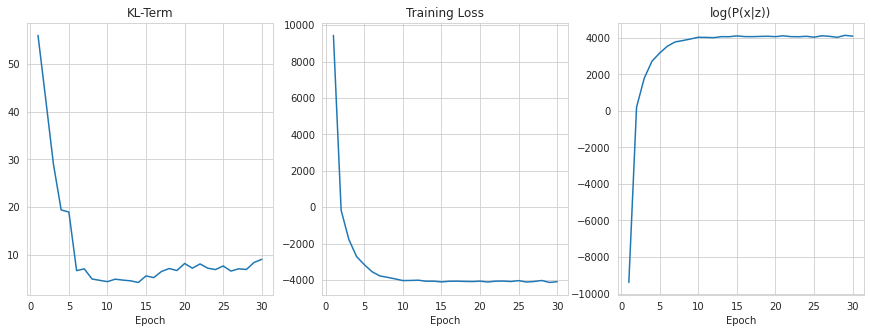

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(1,31), kldat)
plt.title("KL-Term")
plt.xlabel("Epoch")
plt.subplot(1,3,2)
plt.plot(range(1,31), trainlossdat)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.subplot(1,3,3)
plt.plot(range(1,31), logpxdat)
plt.title("log(P(x|z))")
plt.xlabel("Epoch")

## Validating the Network:

It is now time to input some downscaled image and compare the output of the VAE and VI to the true image. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


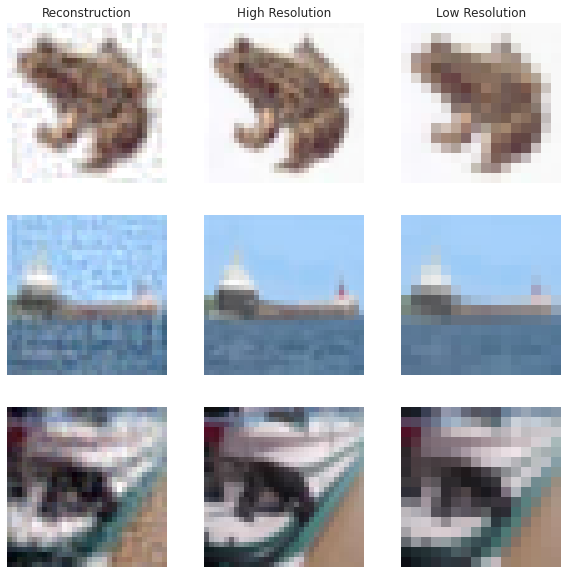

In [ ]:
vae.eval()
x = next(iter(val_loader))
plt.figure(figsize=(10,10))
outputs = vae.sample_from_prior(x) # We should get an image that looks like y
for i in range(0,3):
    tmpx = x[i]
    y = torch.from_numpy(resize(tmpx, output_shape = (3,16,16), mode = 'reflect', anti_aliasing=True))
    px = outputs["px"].mu
    px = px.view(-1, *(3,32,32))
    z = outputs["z"]
    #z = z.view(-1, *(3,16,16))
    #print(y.shape)
    plt.subplot(3,3,i*3+1)
    plt.imshow(px[i].detach().permute(1,2,0))
    plt.axis("off")
    if i == 0:
        plt.title("Reconstruction")
    plt.subplot(3,3,i*3+2)
    plt.imshow(tmpx.detach().permute(1,2,0))
    plt.axis("off")
    if i == 0:
        plt.title("High Resolution")
    plt.subplot(3,3,i*3+3)
    plt.imshow(y.detach().permute(1,2,0))
    if i == 0:
        plt.title("Low Resolution")
    plt.axis("off")
    #plt.subplot(2,2,4)
    #plt.imshow(z[0].detach().permute(1,2,0))

plt.savefig('srvaepics.jpg', format='jpg')

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,